# **House Prices Regression Preprocessing**

This is the house pricing regression of kaggler competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In this notebook, we will carry out preprocessing of the data sets.

In [303]:
#Instalations
#!pip install  rapidfuzz

import numpy as np
import pandas as pd
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns

## **Exploratory Data Analysis**

We have two datasets. The first one is the training dataset, which we will use to train and validate our model. The second one is the test dataset, which is used for the official Kaggle competition. Note that the test dataset does not contain the `SalePrice` column.

In [304]:
# Load the data sets
path_test = "test_raw.csv"
path_train = "train_raw.csv"

df_test = pd.read_csv(path_test)
df_train = pd.read_csv(path_train)

#Number of data in train df
n_train = df_train.shape[0]

# Save target y_train
y_train = df_train['SalePrice'].copy()

# Delete SalePrice
df_train.drop('SalePrice', axis=1, inplace=True)

# Concat
df_concat = pd.concat([df_test, df_train], ignore_index=True)


In [305]:
# See the size of the dataFrames
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
print('Concat shape:', df_concat.shape)


Train shape: (1460, 80)
Test shape: (1459, 80)
Concat shape: (2919, 80)


In [306]:
# Check for the datatype columns and number of non-null values
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [307]:
# Check for the percentage of missing values in the first 10 columns with more missin values
def missing_percentage(df, end=5):
  """
  Check for the percentage of missing values ordered by decreasing order
  df= the data frame
  end= number of columns default 5
  """
  missing_percent = df.isnull().mean() * 100
  print(missing_percent.sort_values(ascending=False)[:end].to_frame())

missing_percentage(df_concat, 10)

                      0
PoolQC        99.657417
MiscFeature   96.402878
Alley         93.216855
Fence         80.438506
MasVnrType    60.500171
FireplaceQu   48.646797
LotFrontage   16.649538
GarageYrBlt    5.447071
GarageCond     5.447071
GarageFinish   5.447071


In [308]:
# Check for negative values in the numerical columns
def check_negative_values(df):
  num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
  neg_values = (df[num_cols] < 0).sum()
  neg_values = neg_values[neg_values > 0]
  return neg_values

print("Negative values in train data set:", check_negative_values(df_concat))

Negative values in train data set: Series([], dtype: int64)


In [309]:
# check for duplicated rows
print("Duplicate values in train data set:", df_concat.duplicated().any())


Duplicate values in train data set: False


In [310]:
# Check for the categories in the categorical columns
def check_categories(df):
  cat_cols = df.select_dtypes(include=['object']).columns.tolist()
  for col in cat_cols:
      print(f"{col}: {df[col].unique()}")

In [311]:
check_categories(df_concat)

MSZoning: ['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
Street: ['Pave' 'Grvl']
Alley: [nan 'Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: ['AllPub' nan 'NoSeWa']
LotConfig: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Condition1: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition2: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAn' 'RRAe']
BldgType: ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
HouseStyle: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofMatl: ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl' 'Metal' 'Membran' 'Roll'
 'ClyTile']
Exterior1

In [312]:
# Check for range in year columns
def check_year_range(df):
  print("Range of year columns:")
  print("YearBuilt:", df['YearBuilt'].min(),'-', df['YearBuilt'].max())
  print("YearRemodAdd:", df['YearRemodAdd'].min(), '-', df['YearRemodAdd'].max())

check_year_range(df_concat)

Range of year columns:
YearBuilt: 1872 - 2010
YearRemodAdd: 1950 - 2010


**Conclusions:** The data has several missing values and typos in categorical data. In the next section we preprocess the data to adress these issues.

## **Cleaning the Data**

In the cleaning data section, we will:

* Clean the data and handle inconsistencies.
* Handle missing values.

From the las section we found that the columns `PoolQ`, `CMiscFeature`, `Alley` and `Fence` are missing more than 80% values. We can drop these columns.

In [313]:
df_concat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [314]:
# To correct typos lets include a dictionary with the valid entries per feature, this values are extracted from the documentation
valid_values_dict = {
    'MSSubClass': [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'],
    'Street': ['Grvl', 'Pave'],
    'Alley': ['Grvl', 'Pave', 'NA'],
    'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
    'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
    'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
    'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'BldgType': ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI'],
    'HouseStyle': ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'],
    'RoofMatl': ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl'],
    'Exterior1st': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'Exterior2nd': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'BrkCmn', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'MasVnrType': ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone'],
    'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'],
    'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
    'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'Heating': ['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'],
    'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'CentralAir': ['Y', 'N'],
    'Electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Salvage'],
    'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageType': ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'NA'],
    'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
    'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'PavedDrive': ['Y', 'P', 'N'],
    'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    'MiscFeature': ['Elev', 'Gar2', 'Othr', 'Shed', 'TenC', 'NA'],
    'SaleType': ['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'],
    'SaleCondition': ['Normal', 'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Partial']
}


In [315]:

########### Functions to preprocess the data #######################

### Handle typos function

def handle_typos(df, valid_dict, threshold=80):
    """
    Correct typos in a DataFrame using a dictionary of valid values.
    Print unmatched non-NaN values for the user to review.

    df         : DataFrame to process
    valid_dict : dictionary {column: valid_values_list}
    threshold  : minimum match percentage for replacement
    """

    # Select columns that are either categorical (object) or numeric (int)
    columns = df.select_dtypes(include=['object', 'int']).columns.tolist()

    # Iterate through each column
    for col in columns:
        if col in valid_dict:  # Only process columns present in the dictionary
            valid_vals = valid_dict[col]  # Get list of valid values for this column
            corrected = []  # Temporary list to store corrected values
            unmatched_values = set()  # Set to store values that could not be corrected

            # Process string columns using fuzzy matching
            if df[col].dtype == 'object':
                # Normalize valid values for comparison (remove spaces and lowercase)
                valid_vals_norm = {str(v).replace(" ", "").lower(): v for v in valid_vals}

                # Iterate through each value in the column
                for val in df[col]:
                    if pd.isna(val) or val in valid_vals:
                        # If value is NaN or already valid, keep it
                        corrected.append(val)
                    else:
                        # Normalize the value
                        val_norm = str(val).replace(" ", "").lower()
                        # Find closest match in valid values
                        match_norm, score, _ = process.extractOne(val_norm, valid_vals_norm.keys(), scorer=fuzz.ratio)
                        if score >= threshold:
                            # If match is good enough, use the matched valid value
                            corrected.append(valid_vals_norm[match_norm])
                        else:
                            # If no good match, keep original and store it for review
                            corrected.append(val)
                            unmatched_values.add(val)

            # Process numeric columns (e.g., MSSubClass)
            else:
                for val in df[col]:
                    if pd.isna(val) or val in valid_vals:
                        # Keep NaN or valid values as is
                        corrected.append(val)
                    else:
                        # Keep original value and store it as unmatched
                        corrected.append(val)
                        unmatched_values.add(val)

            # Print any unmatched values to alert the user
            if unmatched_values:
                print(f"Column '{col}' has unmatched values: {unmatched_values}")

            # Replace original column with corrected values
            df[col] = corrected

    # Return the DataFrame with corrections applied
    return df






### Handle nan values function
def handle_nan(df):

    # Divide columns in numerical and categorical
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    if 'SalePrice' in num_cols:
        num_cols.remove('SalePrice')  # exclude target

    # Fill numerical features with the median
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Categorical: 'None', 'Missing' or mode depending the feature
    fill_with_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
                      'Electrical', 'SaleType', 'SaleCondition']

    fill_with_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                      'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
                      'MasVnrType']



    for column in cat_cols:
        # Fill with 'None'
        if column in fill_with_none:
          df[column] = df[column].fillna('None')
        # Fill with mode
        elif column in fill_with_mode:
          df[column] = df[column].fillna(df[column].mode()[0])
       # Fill with missing
        elif column not in fill_with_none:
            df[column] = df[column].fillna('Missing')


### Function to pre process the data
def preprocess(df):
  handle_typos(df, valid_values_dict)
  handle_nan(df)




In [316]:
# preproces the dataframes
preprocess(df_concat)

Column 'MSZoning' has unmatched values: {'C (all)'}


We found that MSZoning has the input `'C (all)'`, but the valid value is `'C'`, lets fix this issue.

In [317]:
df_concat['MSZoning'] = df_concat['MSZoning'].replace('C (all)', 'C')
df_concat['MSZoning'].unique()

array(['RH', 'RL', 'RM', 'FV', 'C'], dtype=object)

In [318]:
# Check for missing values after processing
print('Missing values percentage in train df')
missing_percentage(df_concat)

Missing values percentage in train df
               0
Id           0.0
MSSubClass   0.0
MSZoning     0.0
LotFrontage  0.0
LotArea      0.0


In [319]:

# Check for the categories in the categorical columns after processing
check_categories(df_concat)

MSZoning: ['RH' 'RL' 'RM' 'FV' 'C']
Street: ['Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['Names' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr' 'Crawfor' 'Blueste' 'IDOTRR'
 'Mitchel' 'Timber' 'MeadowV' 'Veenker']
Condition1: ['Feedr' 'Norm' 'PosN' 'RRNe' 'Artery' 'RRNn' 'PosA' 'RRAn' 'RRAe']
Condition2: ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAn' 'RRAe']
BldgType: ['1Fam' 'TwnhsE' 'Duplx' '2FmCon']
HouseStyle: ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Flat' 'Mansard' 'Shed']
RoofMatl: ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl' 'Metal' 'Membran' 'Roll'
 'ClyTile']
Exterior1st: ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'Meta

## Checking Outliers

In [320]:
# Lets plot boxplots to visualize if there are extreme otliers that can bias our model in the train data.

# Select numerical columns
def plot_boxplots(df, chunk_size=9):
    """
    Plots boxplots for all numerical columns in a DataFrame.
    If there are many columns, splits them into multiple figures for readability.

    Parameters:
    df : pd.DataFrame
        DataFrame with numerical columns to plot.
    chunk_size : int
        Number of columns per figure.
    """
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Loop through columns in chunks
    for i in range(0, len(num_cols), chunk_size):
        chunk = num_cols[i:i+chunk_size]
        n_rows = len(chunk) // 3 + (1 if len(chunk) % 3 != 0 else 0)
        plt.figure(figsize=(15, 5 * n_rows))

        for j, col in enumerate(chunk, 1):
            plt.subplot(n_rows, 3, j)
            sns.boxplot(y=df[col])
            plt.title(col)

        plt.tight_layout()
        plt.show()


Let's vizualize the otliers.

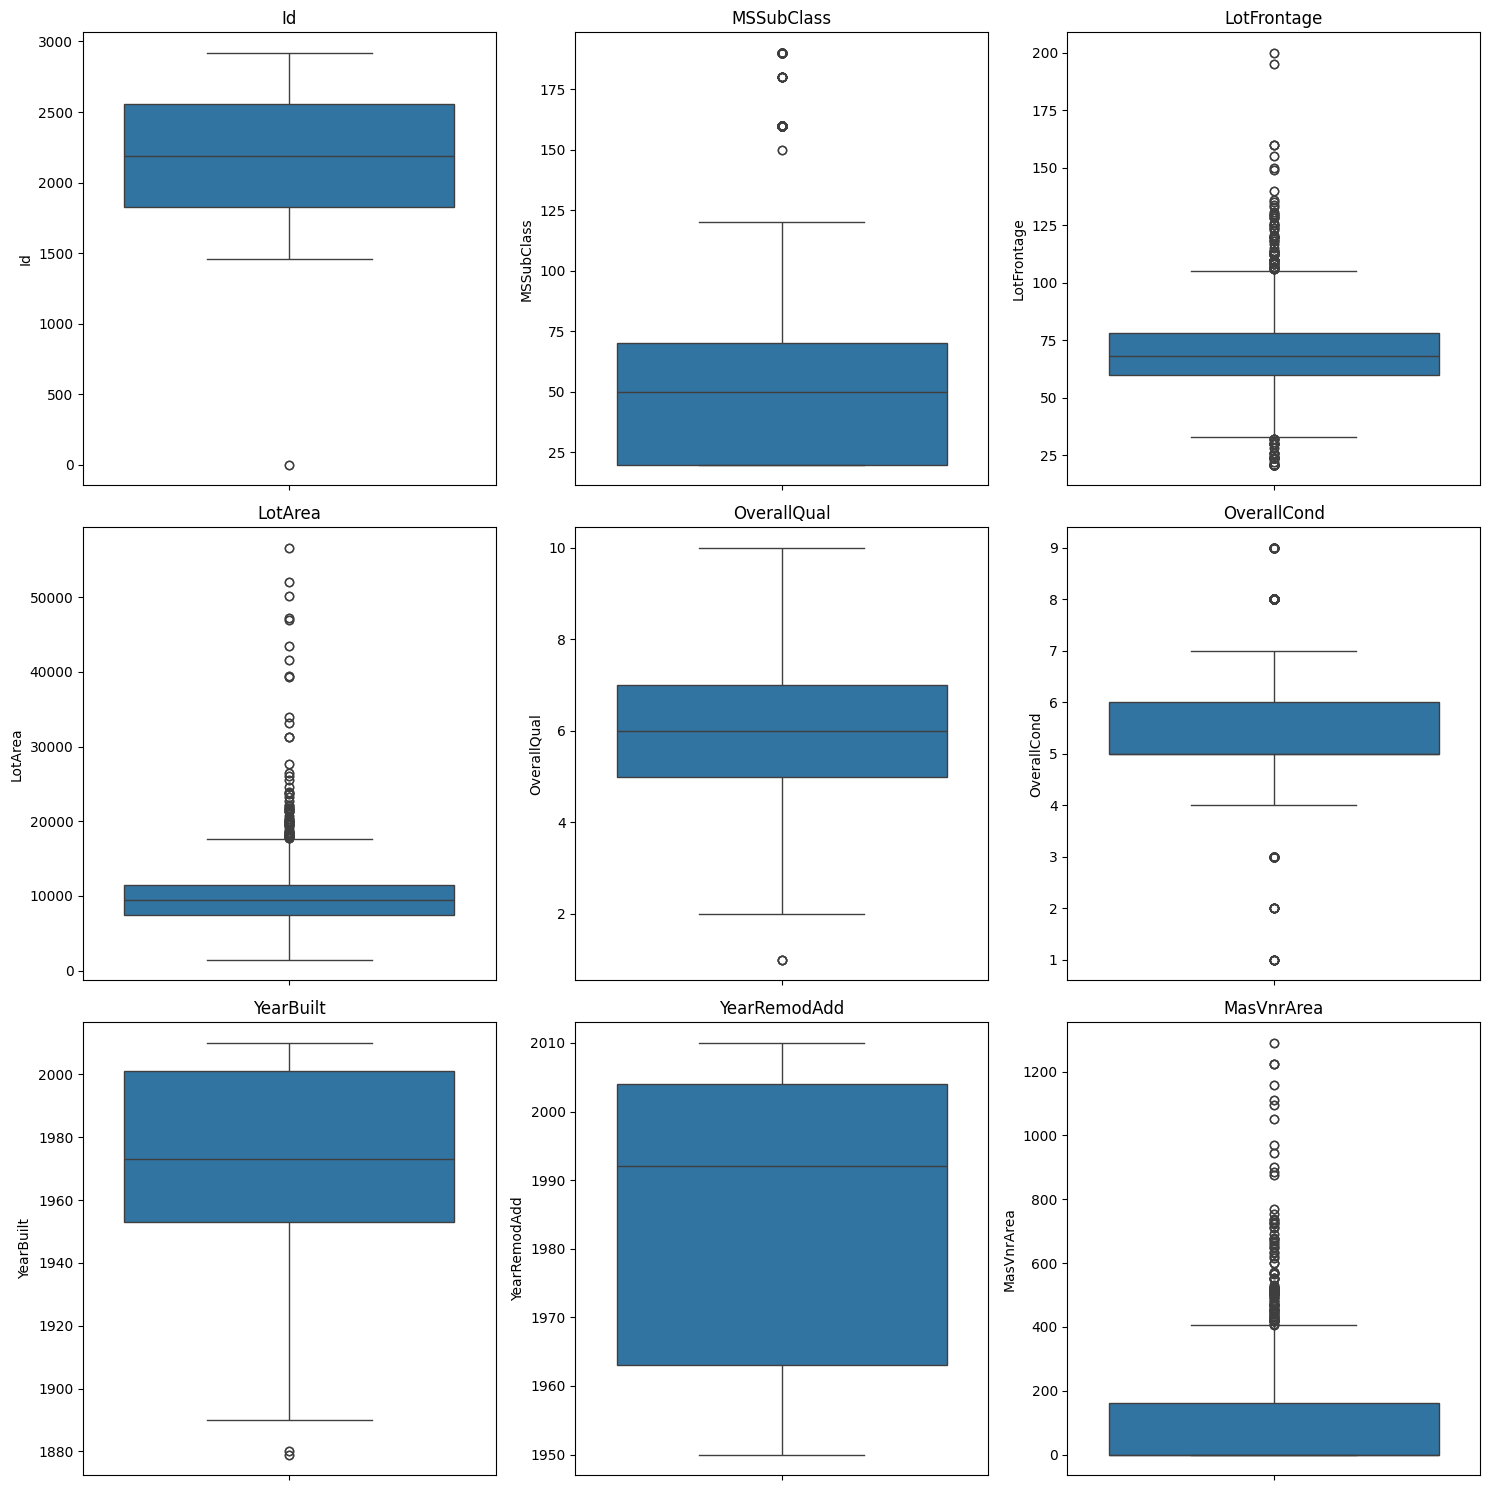

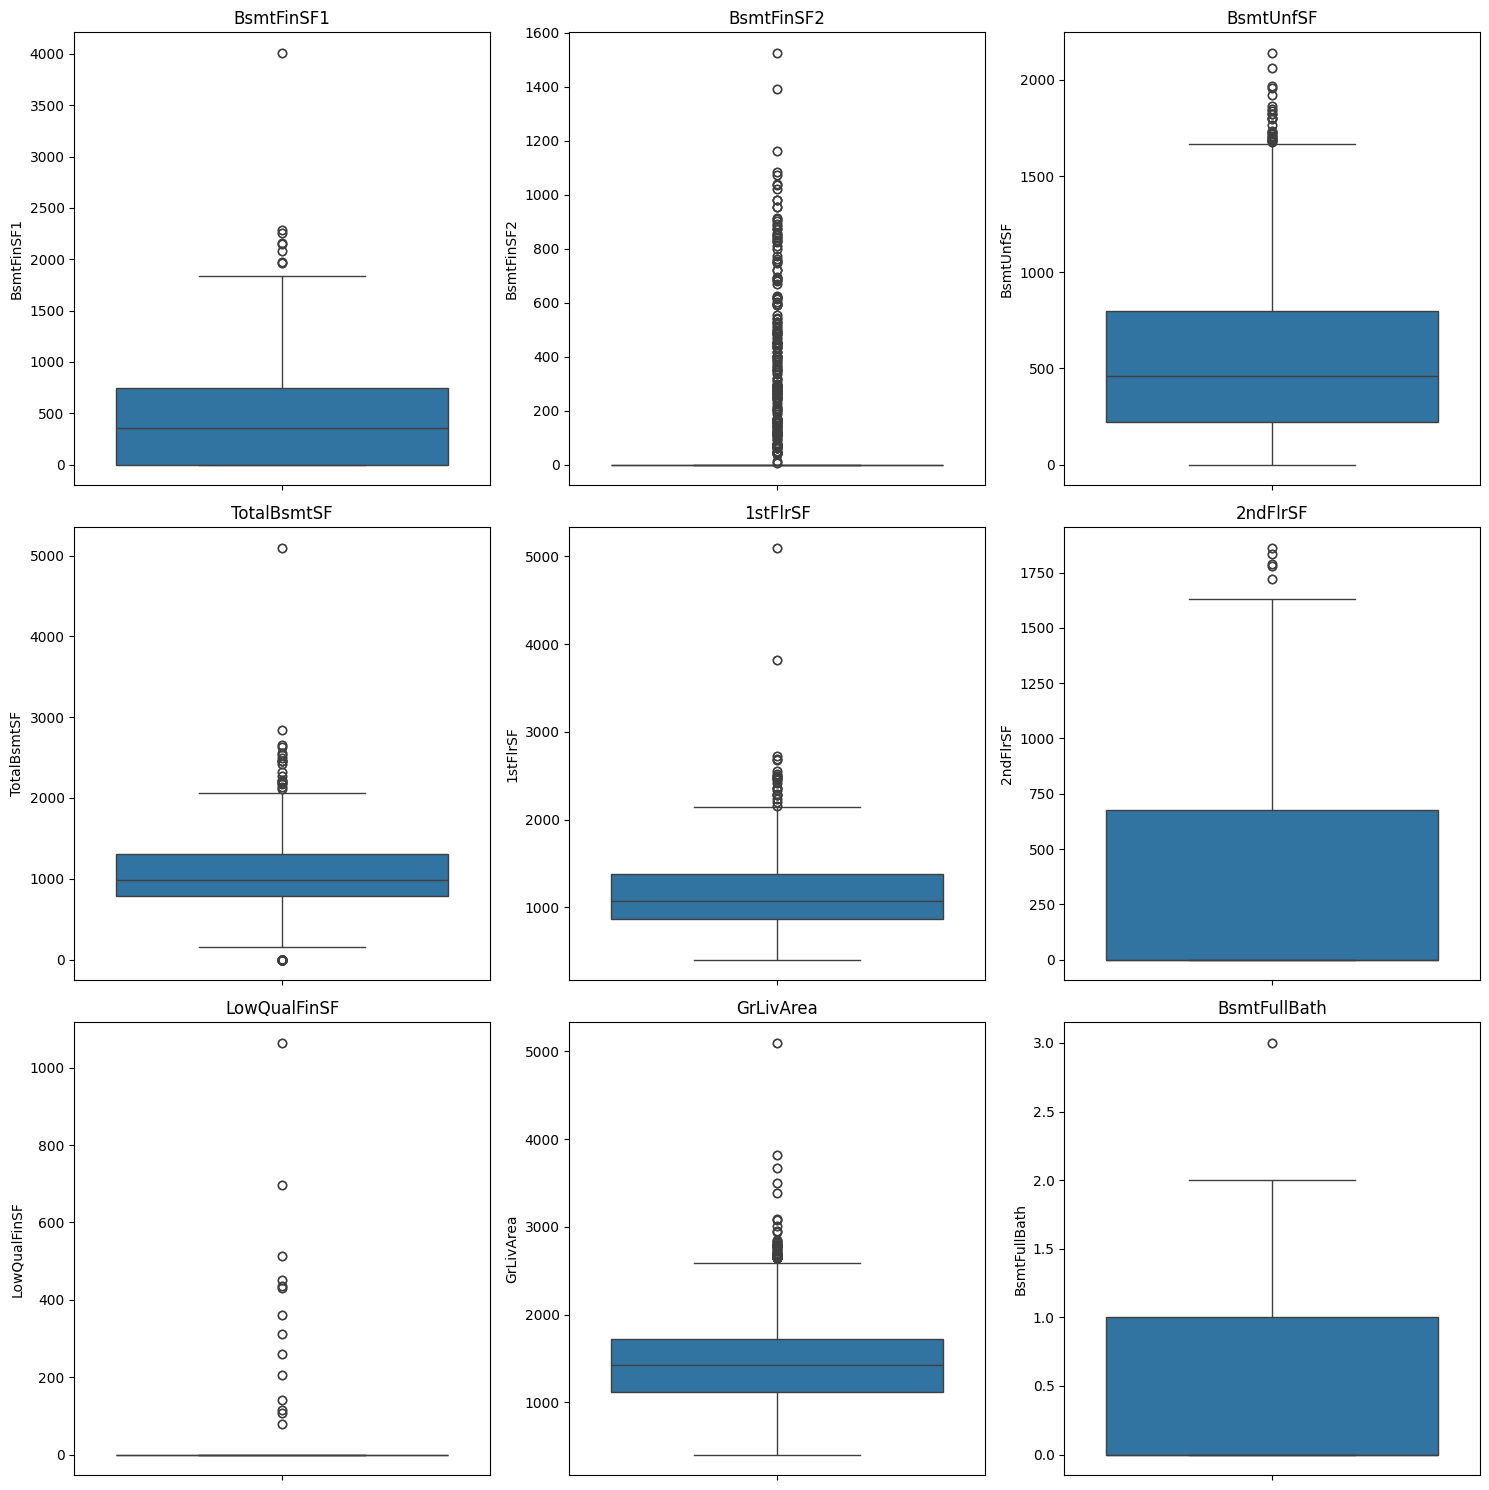

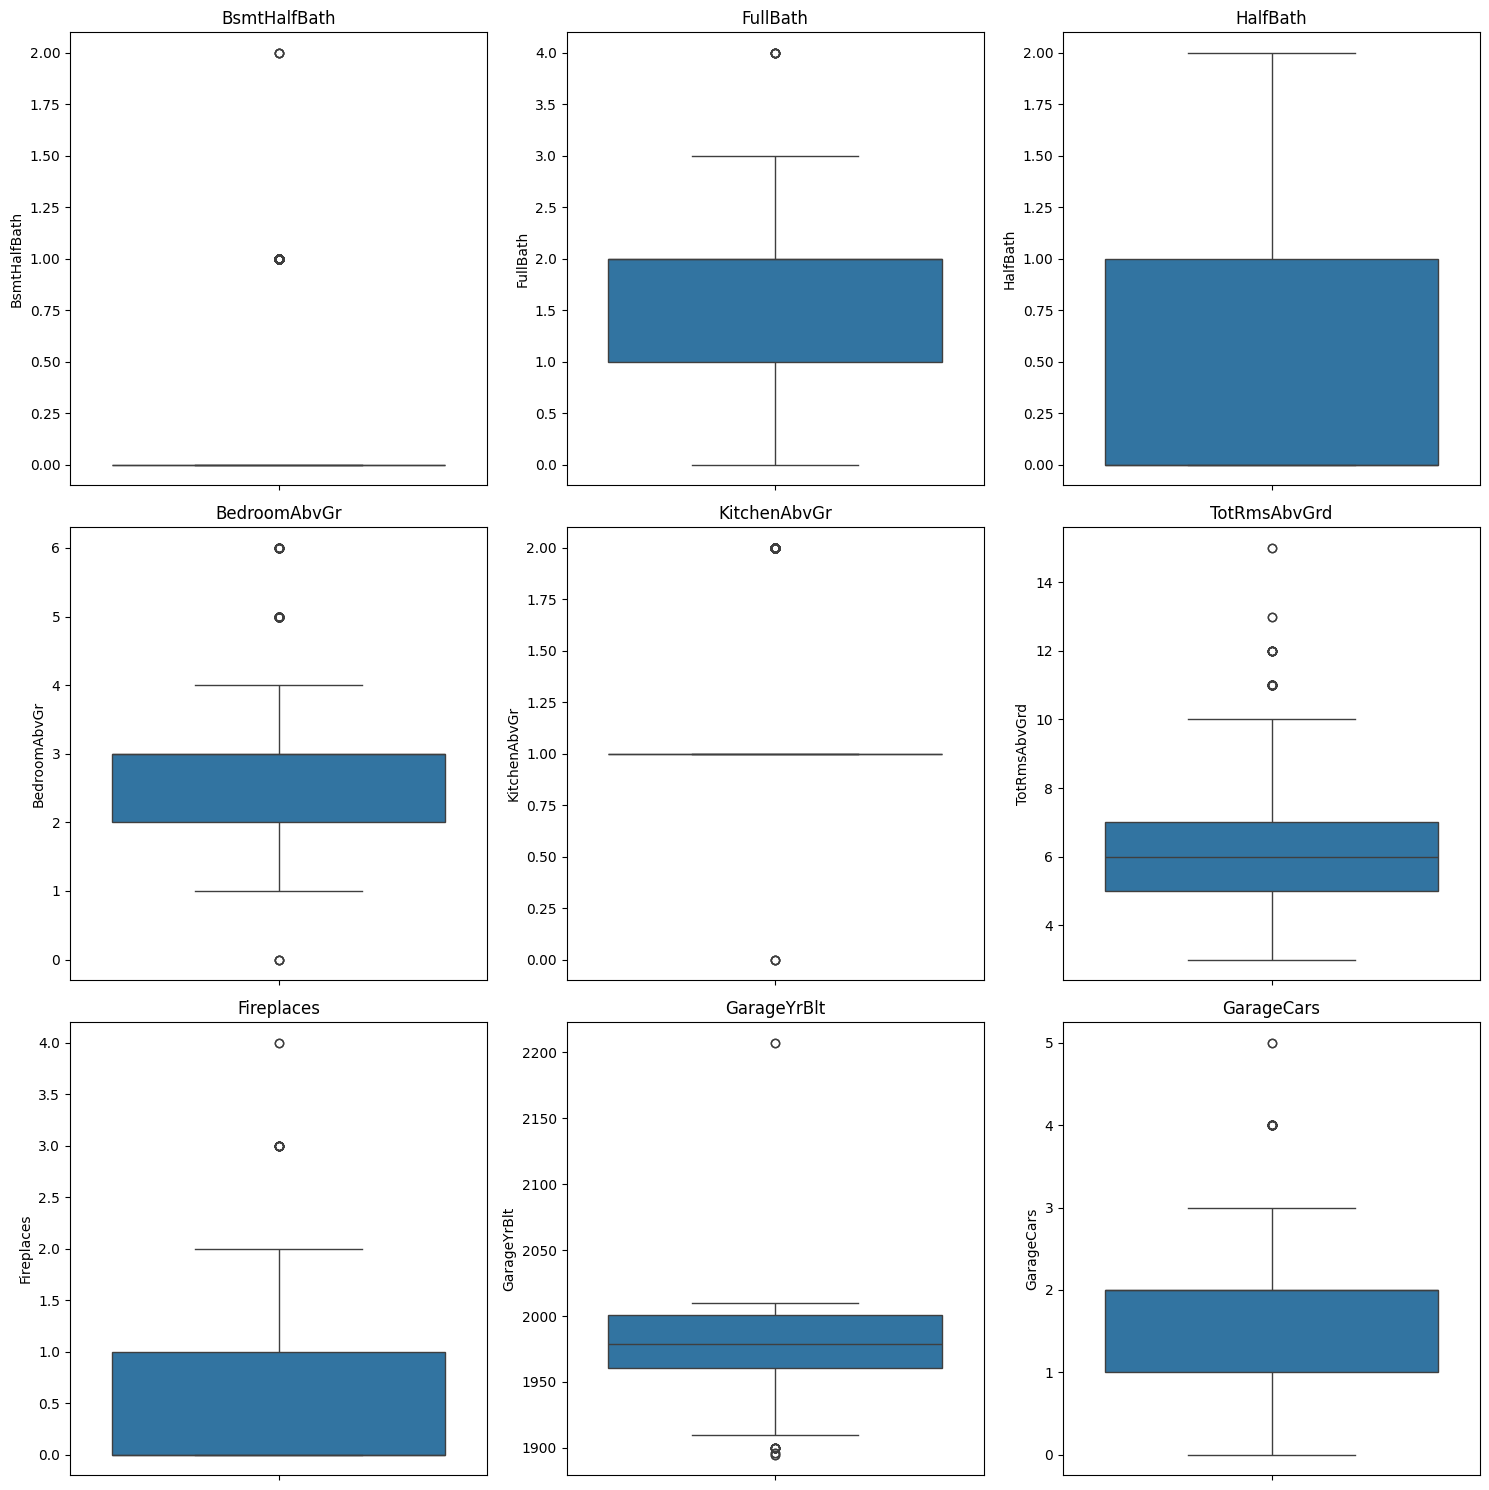

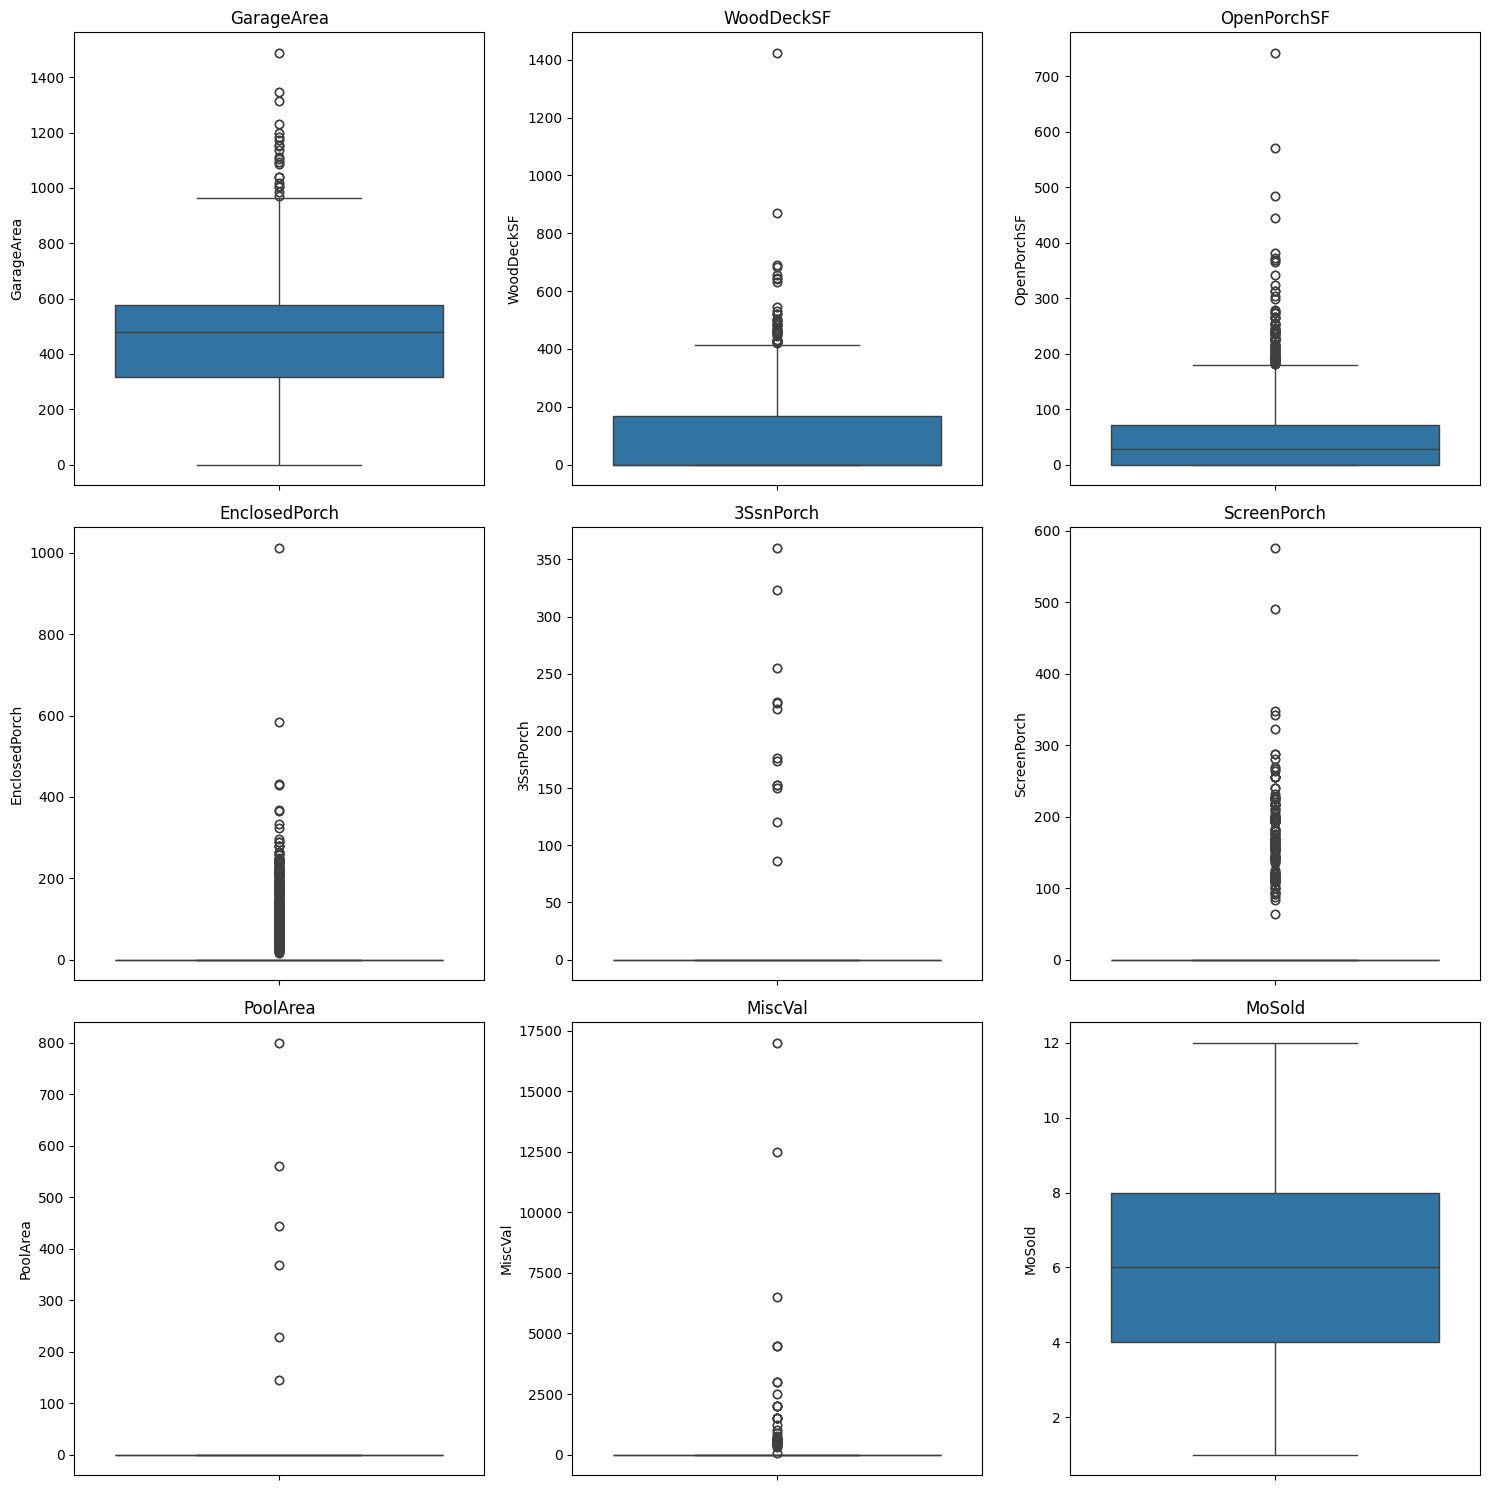

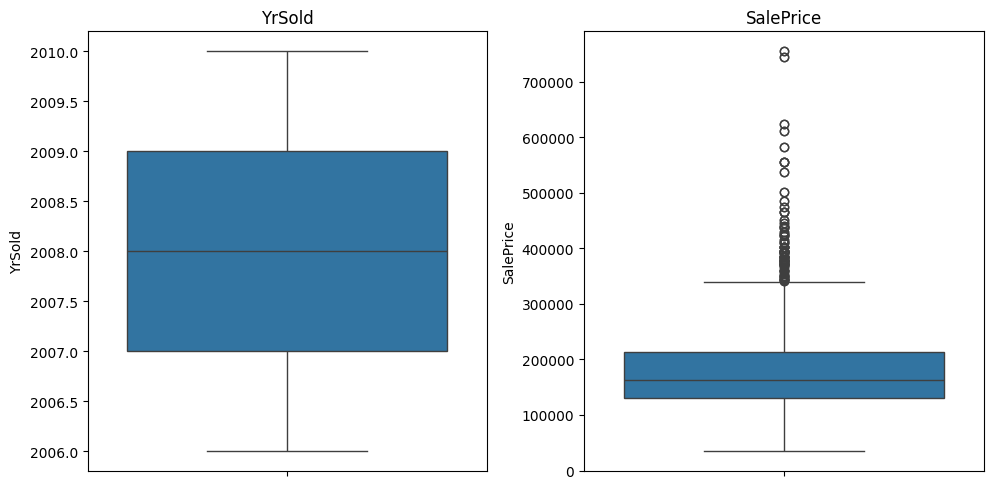

In [321]:
df_train_out=pd.concat([df_concat.iloc[:n_train, :].copy(), y_train])
plot_boxplots(df_train_out)

In the next notebooks, we will use the data to train and evaluate the performance of several models. Some models are more sensitive to outliers, so we will handle them appropriately, applying a logarithmic transformation where needed for each model.

## Rare features
Finally, we will look for exceptional categories in the categorical features.

In [341]:
# Show counts of the categories in categorical features
def count_categories(df):
  cat_cols = df.select_dtypes(include=['object']).columns

  # Show frecuency of each column
  for col in cat_cols:
      print(f"\nColumn: {col}")
      print(df[col].value_counts(dropna=False))

In [323]:
count_categories(df_concat)


Column: MSZoning
MSZoning
RL    2269
RM     460
FV     139
RH      26
C       25
Name: count, dtype: int64

Column: Street
Street
Pave    2907
Grvl      12
Name: count, dtype: int64

Column: LotShape
LotShape
Reg    1859
IR1     968
IR2      76
IR3      16
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: count, dtype: int64

Column: Utilities
Utilities
AllPub    2918
NoSeWa       1
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl    2778
Mod     125
Sev      16
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Names      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU   

We see that there are many categories with rare occurrences, so we group these by creating a new category called 'Other'. We use a threshold of 4%.

In [324]:
def group_rare_categories(df, min_freq=0.04):
    """
    Replace rare categories (less frequent than min_freq) with 'Other'
    in all categorical columns of the DataFrame.

    Parameters:
    df : pd.DataFrame
        DataFrame to process.
    min_freq : float
        Minimum frequency (proportion) a category must have to not be considered rare.
    """
    # Select all categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns

    for col in cat_cols:
        # Compute the frequency of each category
        freq = df[col].value_counts(normalize=True)
        # Identify rare categories
        rare_values = freq[freq < min_freq].index
        # Replace rare categories with 'Other'
        df[col] = df[col].replace(rare_values, 'Other')




In [325]:
group_rare_categories(df_concat)

In [326]:
count_categories(df_concat)


Column: MSZoning
MSZoning
RL       2269
RM        460
FV        139
Other      51
Name: count, dtype: int64

Column: Street
Street
Pave     2907
Other      12
Name: count, dtype: int64

Column: LotShape
LotShape
Reg      1859
IR1       968
Other      92
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl      2622
HLS       120
Bnk       117
Other      60
Name: count, dtype: int64

Column: Utilities
Utilities
AllPub    2918
Other        1
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2133
Corner      511
CulDSac     176
Other        99
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl      2778
Mod       125
Other      16
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Other      856
Names      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Name: count, dtype: int64

Column: Condition1
Condition1
Norm     2511
Other     244
Feedr     164
Name

Lets drop the columns `street` and `Utilities` that have big concentration of categories in one category.

In [327]:
df_concat.drop(['Street', 'Utilities'], axis=1, inplace=True)

To end the preprocessing, let's merge the 'Other' category with the most common value in those categories where there are few 'Other' values. We use a threshole of 5% as a criterion to merge.

In [328]:
# Function to merge 'Other' with most common category
def merge_other_with_most_frequent(df, threshold=0.05):
  cat_cols = df.select_dtypes(include=['object']).columns
  for column in cat_cols:
    value_counts = df[column].value_counts(normalize=True)
    if 'Other' in value_counts and value_counts['Other'] < threshold:
        most_common = value_counts.drop('Other').idxmax()
        df[column] = df[column].replace('Other', most_common)

In [329]:
merge_other_with_most_frequent(df_concat)
count_categories(df_concat)


Column: MSZoning
MSZoning
RL    2320
RM     460
FV     139
Name: count, dtype: int64

Column: LotShape
LotShape
Reg    1951
IR1     968
Name: count, dtype: int64

Column: LandContour
LandContour
Lvl    2682
HLS     120
Bnk     117
Name: count, dtype: int64

Column: LotConfig
LotConfig
Inside     2232
Corner      511
CulDSac     176
Name: count, dtype: int64

Column: LandSlope
LandSlope
Gtl    2794
Mod     125
Name: count, dtype: int64

Column: Neighborhood
Neighborhood
Other      856
Names      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Name: count, dtype: int64

Column: Condition1
Condition1
Norm     2511
Other     244
Feedr     164
Name: count, dtype: int64

Column: Condition2
Condition2
Norm    2919
Name: count, dtype: int64

Column: BldgType
BldgType
1Fam      2425
TwnhsE     323
Other      171
Name: count, dtype: int64

Column: HouseStyle
HouseStyle
1Story    1605
2Story     872
1.5Fin

In [339]:
df_train_pre = pd.concat([df_concat.iloc[:n_train, :], y_train.reset_index(drop=True)], axis=1)
df_test_pre = df_concat.iloc[n_train:, :]

In [340]:
# Save the preprocess data set in .csv
df_train_pre.to_csv('train_pre.csv')
df_test_pre.to_csv('test_pre.csv')